Group Number: #127
<br>
Names: Alex Oprea, Kristen Duong
<br>
Student Numbers: 300230368, 300240425

# Introduction
In this notebook, we perform a classification emperical study on the "Stroke Prediction Dataset", using a decision tree to predict the likelihood of stroke. We start by cleaning up the dataset and encoding the values for better usage. We then create different ways to improve the data for prediction, including outlier removal and the creation of aggregated columns. In the end, we try multiple combinations of prediction tests to see the best one, before doing our final prediction.

To use this notebook, the user must be able to import libraries pandas, math, seaborn, matplotlib, lightgbm and sklearn

# Description
<i>Dataset name:</i> Stroke Prediction Dataset<br>
<i>Purpose:</i> The purpose of this dataset is to indicate and later predict whether someone is going to have a stroke based on their living habits and pre-existing health conditions.
<br>
<i>Domain:</i> Healthcare, Medicine<br>
<i>Audience:</i> Doctors who want to help stroke patients, or figure out howlikely their patient is to get a stroke and people who want to adjust their lifestyle to lower their risk of getting a stroke.<br>
<br>
<i>Categorical Attributes:</i>
- gender: Represents the gender of the person
- hypertension: Boolean variable, representing whether the person has hypertension or not (1 for yes, 0 for no)
- heart_disease: Boolean variable, representing whether the person has a heart_disease or not
- ever_married: Boolean variable (yes or no) representing if someone’s ever been married.
- work_type: indicates the employment status and type of the person
- Residence_type: Indicates whether the person lives in a rural or urban area
- smoking_status: indicates whether the person is currently or has ever smoked.
- stroke: boolean variable indicating whether the person had a stroke or not.

<i>Numerical Attributes:</i>
- id: Number to represent/distinguish the different people studied
- age: Represents the age of the person
- avg_glucose_level: the average glucose level of the person’s blood
- bmi: The body mass index of the person


In [141]:
# Import libraries
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

# load csv files from github
stroke = pd.read_csv('https://raw.githubusercontent.com/kkristene3/CSI4142_Datasets/refs/heads/main/stroke.csv')

# Classification Emperical Study

Part a: Cleaning the data<br>
Looking at the dataset, we've determined the things to take into consideration:
1. "bmi" column with the nan values
2. Since these are all different people, there should be no exact duplicates
3. The "unknown" value in the "smoking_status" column
4. The ranges of the numerical attributes

In [169]:
#The dataset has some N/A values in its bmi column. There aren't many, so we can just remove those rows; it shouldn't have much of an impact on the end result.
cleanStroke = stroke.copy()
rows = []

#if the row has a nan column, we want to flag it as an index we wanna get rid of
for index, row in stroke.iterrows():
    floated = float(row["bmi"])
    if math.isnan(floated):
        rows.append(index)

#getting rid of the rows that have nan in them
for i in rows:
    cleanStroke = cleanStroke.drop(index=i)

#resetting the indexes so the removal of the nan rows doesn't impact the dataset
cleanStroke = cleanStroke.reset_index(drop=True)

#We also want to remove exact duplicates (that would be the same person). Near duplicates are not a concern since the study includes people
#If the id is different, that means that the study is referring to 2 different people (even if their information is the same).
#Additionally, since these are people and not an instance of an event, there definitely exists people in the world that have the same information for all these rows since none of them include any personal, unique information
cleanStroke = cleanStroke.drop_duplicates()

#resetting the indexes so the removal of the dataset
cleanStroke = cleanStroke.reset_index(drop=True)

#Finally, there is the "Unknown" value in the smoking_status row
#If "Unknown" means that the person doesn't know whether or not they've smokes, we can assume this would present similar results as "never smoked"
#We are looking at smoking as a lifestyle more than an occurence, so if the user can't even remember smoking, then they couldn't have smoked enough to create an impact on their life
#So, we will replace all "Unknown" values with "never smoked"
for index, row in cleanStroke.iterrows():
    if (row["smoking_status"] == "Unknown"):
        cleanStroke.loc[index, "smoking_status"] = "never smoked"

#bmi, age and glucose_level don't have specific ranges but they shouldn't be below 0, so we should make sure there are none of those
#if they are there, we want to get rid of the row because it is not valid
for ind, row in cleanStroke.iterrows():
    if (row["bmi"]<0 or row["age"]<0 or row["avg_glucose_level"]<0):
        cleanStroke = cleanStroke.drop(index=ind)

#resetting the indexes so the removal of the dataset
cleanStroke = cleanStroke.reset_index(drop=True)



Part b: Numerical Feature Encoding <br>
There are 3 numerical columns that could be grouped into bins:
1. "bmi": There are already pre-set ranges for the bins on the internet. After a bit of research, this attribute could be divided into 6 categories
2. "age": Split by developmental stage
3. "avg_glucose_level": Split by diagnoses typically given for glucose level ranges (also found on internet)

In [170]:
#creating a function for numerical feature encoding

def encodeFeatures(binnedStroke):
    
    #For the BMI column, we want to bin based on the medically known ranges (typically would be domain knowledge but I found it by searching it up)
    bins = [0, 18.5, 24.9, 29.9, 34.9, 39.9, 100]
    categories = ["Underweight", "Normal Weight", "Overweight", "Obese class I", "Obese class II", "Obese class III"]
    
    binnedStroke["bmi_bin"] = pd.cut(binnedStroke["bmi"], bins=bins, labels=categories)
    
    #For the Age column, we can bin ages by age-group
    categories = ["Infant", "Toddler", "Child", "Adolescent", "Young Adult", "Middle Adult", "Senior Adult"]
    bins = [0, 1.9, 4.9, 12.9, 19.9, 39.9, 59.9, 100]
    
    binnedStroke["age_bin"] = pd.cut(binnedStroke["age"], bins=bins, labels=categories)
    
    #binning avg_glucose level needs domain knowledge, but after some research, we find that we can bin it based on the implication is has for your health
    categories = ["Hypoglycemic", "Normal", "Prediabetic", "Diabetic"]
    bins = [0, 69, 99, 125, 300]
    
    binnedStroke["glucose_bin"] = pd.cut(binnedStroke["avg_glucose_level"], bins=bins, labels=categories)
    
    #Now that all the numeric columns have been binned, we can get rid of the old columns
    del binnedStroke["bmi"]
    del binnedStroke["age"]
    del binnedStroke["avg_glucose_level"]


Part c: EDA and Outlier Detection
<br>The only columns that are realistically at risk for outliers are the numeric ones, so we plot them all in box plots. If we see enough outliers, we will do the LOF for those columns.

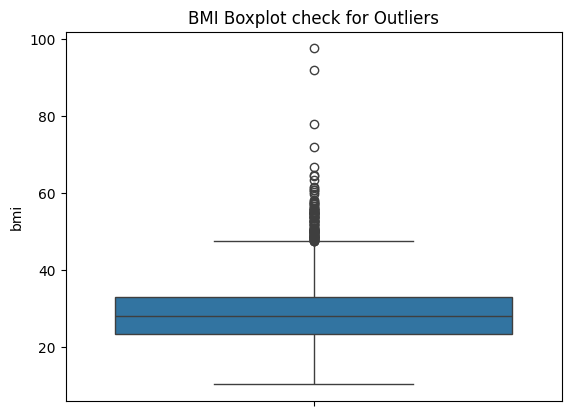

In [119]:
#The three numerical columns we need to search for outliers are bmi, age and avg_glucose_level (the categorical ones all have expected values after the cleaning in part a)
#To see possible outliers with EDF, we will draw boxplots
#First, bmi:
sns.boxplot(y=cleanStroke["bmi"])
plt.title("BMI Boxplot check for Outliers")
plt.show()

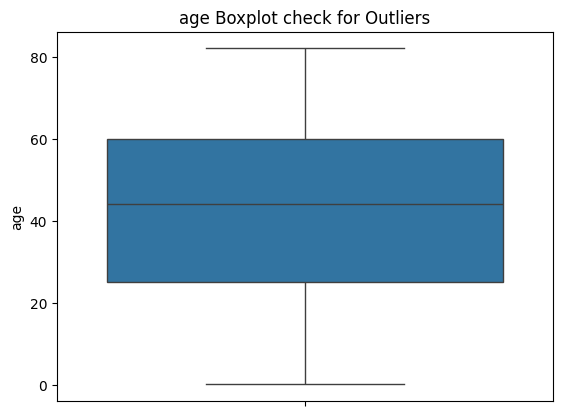

In [85]:
sns.boxplot(y=cleanStroke["age"])
plt.title("Age Boxplot check for Outliers")
plt.show()

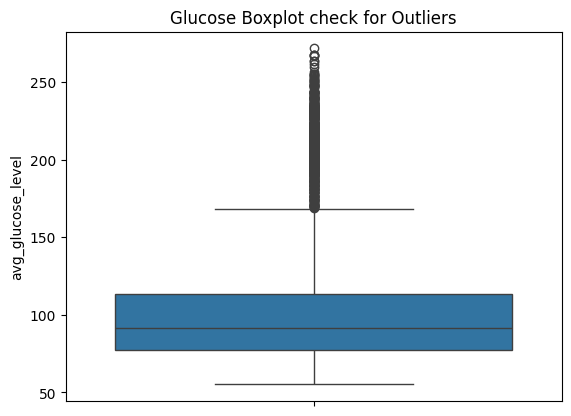

In [120]:
sns.boxplot(y=cleanStroke["avg_glucose_level"])
plt.title("Glucose Boxplot check for Outliers")
plt.show()

In [200]:
print("For BMI and Glucose, these boxplots show a lot of points on top of the Q3. Looking at these, I'd assume that these two columns have many outliers.")
print("However, due to the purpose of this dataset, I would assume that a lot of these extreme values flagged as 'outliers' are intentional.")
print("If people were to get a stroke at an unexpected time in their lives, it would make sense to look for extreme values in these two columns.")
print("Since it is required by the assignment to deal with outliers, I will flag some values as outliers anyways and remove them (but make the contamination value low so we don't lose too much data).")
print("Age doesn't have any points in the boxplot and can therefore be safe from the outlier check.")
def findOutliers(dat, column):
    outlierRows  = []
    outlierSet = dat.copy()
    lof = LocalOutlierFactor(n_neighbors=50, contamination=0.1) 
    row = dat[[column]].values
    outlierStatus = lof.fit_predict(row)

    outlierSet['Outlier Status'] = outlierStatus

    for index, row in outlierSet.iterrows():
        #if the status is -1, then it is an outlier
        if row['Outlier Status'] == -1:
            outlierRows.append(index)

    for i in outlierRows:
        dat = dat.drop(index=i)

    dat = dat.reset_index(drop=True)

    return dat

def removeOutliers(dat):
    dat = findOutliers(dat, "bmi")
    dat = findOutliers(dat, "avg_glucose_level")
    return dat


For BMI and Glucose, these boxplots show a lot of points on top of the Q3. Looking at these, I'd assume that these two columns have many outliers.
However, due to the purpose of this dataset, I would assume that a lot of these extreme values flagged as 'outliers' are intentional.
If people were to get a stroke at an unexpected time in their lives, it would make sense to look for extreme values in these two columns.
Since it is required by the assignment to deal with outliers, I will flag some values as outliers anyways and remove them (but make the contamination value low so we don't lose too much data).
Age doesn't have any points in the boxplot and can therefore be safe from the outlier check.


Part d: Predictive Analysis (Decision Trees)
<br>Following experimentation with the different parameters in the DecisionTreeClassifier class, this function includes the values we decied on. It will be called during the future parts.

In [172]:
#target is the column we want to predict
def createDecisionTree(dataset1, testSet1, target):

    categorical_columns = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
    dataset = dataset1.copy()
    testSet = testSet1.copy()

    # Convert categorical columns to category dtype
    for col in categorical_columns:
        dataset[col] = dataset[col].astype('category')
        testSet[col] = testSet[col].astype('category')

    #we start by splitting the dataset into the rest of the dataset and the target column
    restOfDataset = dataset.drop(target, axis=1) 
    guessColumn = dataset[target]

    #do the same to the test set
    restOfTestData = testSet.drop(target, axis=1)
    testGuessColumn = testSet[target]

    #Create the tree classifier
    tree = lgb.LGBMClassifier(objective='binary', boosting_type='gbdt', random_state=42, class_weight='balanced', verbose=-1)

    #build the tree
    tree.fit(restOfDataset, guessColumn, categorical_feature=categorical_columns)

    #predict the test set values with the tree
    predictedTarg = tree.predict(restOfTestData)

    #return the prediction score from the decision tree
    return accuracy_score(testGuessColumn, predictedTarg)
    
    

Part e: Feature Engineering<br>
Creating 2 new features:
1. A sum of bmi and avg_glucose_level - if both of these are high, the likelihood of a stroke is much higher. So, bigger sums = bigger chance of stroke
2. A ratio of age to bmi - As people grow and develop with age, their weight should typically be in a certain range. Any number that is way too small (aka huge bmi in comparison to size) could be indicative of a stroke.

In [192]:
def createNewFeatures(dataset):
    for index, row in dataset.iterrows():
        #add values to sum column
        dataset.loc[index, "bmi_glucose"] = row["bmi"] + row["avg_glucose_level"]

        #add values to ratio column (numbers are multiplied by 100 at the end to ensure they are not unnecessarily small)
        dataset.loc[index, "age_bmi_ratio"] = row["age"]/row["bmi"]*100

    return dataset


Part f: Empirical Study

In [205]:
#We start by splitting the dataset (cleanStroke) into 3 groups. We do this before the feature encoding because once we group our numeric attributes into categories, we lose our outlier/summing work
#Assign 30% of the set to testing, 70% to the temporary set
testSet, trainSet = train_test_split(cleanStroke, test_size=0.3, random_state=42)

#We need to prepare for our 4-fold cross-validation:
kf = KFold(n_splits=4, shuffle=True, random_state=42)

#Next, we want to do all our tests. First, we do DR1 (original dataset). Since no further modifications must be done, we can do feature encoding now
DR1Set = trainSet.copy()
encodeFeatures(DR1Set)

average = 0
count = 1
print("DR1 - Original Dataset:")
# Performing the 4-fold split
for fold, (train_index, val_index) in enumerate(kf.split(DR1Set), 1):
    score = createDecisionTree(DR1Set.iloc[train_index], DR1Set.iloc[val_index], "stroke")
    average += score
    print("Test", count, ":", score)
    count+=1
average = average/4

print("After doing a 4-fold cross-validation of DR1 (the original dataset), the average score is", average)

#Next, we do DR2 (without outlier)
DR2Set = trainSet.copy()
#Remove outliers
DR2Set = removeOutliers(DR2Set)
encodeFeatures(DR2Set)

average = 0
count = 1
print("\nDR2 - Outlier Removal:")
# Performing the 4-fold split
for fold, (train_index, val_index) in enumerate(kf.split(DR2Set), 1):
    score = createDecisionTree(DR2Set.iloc[train_index], DR2Set.iloc[val_index], "stroke")
    average += score
    print("Test", count, ":", score)
    count+=1
average = average/4

print("After doing a 4-fold cross-validation of DR2 (the dataset without outliers), the average score is", average)

#Next, we do DR3 (with aggregation)
DR3Set = trainSet.copy()
#Add aggregation
DR3Set = createNewFeatures(DR3Set)
encodeFeatures(DR3Set)

average = 0
count = 1
print("\nDR3 - Has Aggregation:")
# Performing the 4-fold split
for fold, (train_index, val_index) in enumerate(kf.split(DR3Set), 1):
    score = createDecisionTree(DR3Set.iloc[train_index], DR3Set.iloc[val_index], "stroke")
    average += score
    print("Test", count, ":", score)
    count+=1
average = average/4

print("After doing a 4-fold cross-validation of DR3 (dataset with aggregation), the average score is", average)

#Finally we do DR4 with both aggregation and no outliers
DR4Set = trainSet.copy()
#Remove outliers
DR4Set = removeOutliers(DR4Set)
#Add aggregation
DR4Set = createNewFeatures(DR4Set)
encodeFeatures(DR4Set)

average = 0
count = 1
print("\nDR4 - Has Aggregation and no outliers:")
# Performing the 4-fold split
for fold, (train_index, val_index) in enumerate(kf.split(DR4Set), 1):
    score = createDecisionTree(DR4Set.iloc[train_index], DR4Set.iloc[val_index], "stroke")
    average += score
    print("Test", count, ":", score)
    count+=1
average = average/4

print("After doing a 4-fold cross-validation of DR4 (dataset with aggregation and no outliers), the average score is", average)

print("\nSo, out of all the test results, DR4 (with 2 extra aggregated columns and outliers removed) did the best (it had the highest average score, yay). That means that it is the best method to use for our final test:")

print("Final Test with test data (Method DR4)")
finalTest = trainSet.copy()
finalTest= removeOutliers(finalTest)
finalTest = createNewFeatures(finalTest)
encodeFeatures(finalTest)

testSet= removeOutliers(testSet)
testSet = createNewFeatures(testSet)
encodeFeatures(testSet)

score = createDecisionTree(finalTest, testSet, "stroke")
print("The score of the final test is", score)



DR1 - Original Dataset:
Test 1 : 0.9024390243902439
Test 2 : 0.9157608695652174
Test 3 : 0.9211956521739131
Test 4 : 0.9184782608695652
After doing a 4-fold cross-validation of DR1 (the original dataset), the average score is 0.914468451749735

DR2 - Outlier Removal:
Test 1 : 0.9264214046822743
Test 2 : 0.9364548494983278
Test 3 : 0.9230769230769231
Test 4 : 0.9395973154362416
After doing a 4-fold cross-validation of DR2 (the dataset without outliers), the average score is 0.9313876231734417

DR3 - Has Aggregation:
Test 1 : 0.9349593495934959
Test 2 : 0.9402173913043478
Test 3 : 0.9347826086956522
Test 4 : 0.9320652173913043
After doing a 4-fold cross-validation of DR3 (dataset with aggregation), the average score is 0.9355061417462001

DR4 - Has Aggregation and no outliers:
Test 1 : 0.9264214046822743
Test 2 : 0.9364548494983278
Test 3 : 0.9431438127090301
Test 4 : 0.9395973154362416
After doing a 4-fold cross-validation of DR4 (dataset with aggregation and no outliers), the average s

Part g: Result Analysis<br>
a) As seen above, we could see an increase in performance between the performance of the original dataset (DR1) and the dataset with the outliers removed (DR2) by approx 0.017, then again between the one with the outliers removed (DR2) and the one with aggregated columns (DR3) by approx 0.004, and finally between DR3 and the set with the aggregated columns and outliers removed (DR4) by approx 0.001. This means that DR4 is the best approach (though it should be noted that it is only by a very small amount).<br><br>
b) Seeing as all 3 tests that include outlier removal and/or aggregation do better than the original dataset (by at least 0.017), it's clear that they have a positive result on the outcome. We can see that aggregation has a slightly better impact than just outlier removal (probably because aggregated columns were created specifically to aid the prediction), but we can really see that they make a good impact by the way that DR4 is the best method. They both show significant improvement on their own, but the fact that they do the best together proves that this improvement is causation and not just correlation. In the case of the outliers, this is probably because these extreme values add noise to the prediction, requiring the tree to unnecessarily create further branches that might mess with past routes (which would work better for the more common values). For aggregation, since we created these columns knowing that they would help the prediction in the end, it is not much of a surprise that they succeeded.<br><br>
c) The results of the final test are pretty on par with the expectations created by the original 4 tests. The result is better than the all the methods attempted (including the 3 discarded ones) and is only slightly better than the average test scores of the chosen method (0.004 improvement). If we look at the final result in comparison to the individual tests of the 4-fold cross-validations, we see that the final result is better than any of the tests for methods DR1-DR3, but it is within the range of the results for DR4. This proves that the noted improvement between the methods is real and that we truly chose the best validation method for our final result. The result being as expected also proves that our prediction model is working well, with its score values being consistent and not random spit out values.

# Conclusion
In this notebook, we perfored a classification emperical study by creating and training a decision tree model. We performed multiple 4-fold cross-validation tests with different requirements added in and discovered that the best prediction set had both the removal of its outliers and additional aggregated columns. We managed to confirm this discovery with a successful final test on test data that we put aside and left untouched. We gained valuable experience with the tasks of data cleaning, outlier detection and predictive analysis. The results to all our tests in this assignment were satisfactory and as expected.

# References
- BMI bins: https://www.canada.ca/en/health-canada/services/food-nutrition/healthy-eating/healthy-weights/canadian-guidelines-body-weight-classification-adults/body-mass-index-nomogram.html
- Glucose bins: https://www.diabetes.co.uk/diabetes_care/blood-sugar-level-ranges.html
- LOF documentation: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html
- Decision Tree documentation: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

ChatGPT:
- Help splitting up dataset:
   ```python
    # First, split into training set (60%) and temporary set (40%)
    X_train, X_temp = train_test_split(df, test_size=0.4, random_state=42)
    ```
   and
  ```python
  # Define 4-fold cross-validation
    kf = KFold(n_splits=4, shuffle=True, random_state=42)

    # Performing the 4-fold split
    for fold, (train_index, val_index) in enumerate(kf.split(df), 1):
    ```